In [2]:
!pip install torch torchvision torchaudio scikit-learn medmnist

In [2]:
"""
Created on Mon Aug4 17:35:36 2025

@author: vigo
"""

import os
import sys
import argparse
import time
import pickle
from tqdm import trange
import numpy as np
import PIL
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50
import matplotlib.pyplot as plt
from scipy.io import savemat

#Related medmnist dataset
import medmnist
from medmnist import INFO, Evaluator

# Check for Cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 27
torch.manual_seed(seed)
random.seed(seed)

# Hyper-parameters 
n_epochs = 10
batch_size = 128
lr = 0.0005

#Network Hyper-parameters
hidden_size = 512

data_flag = 'organamnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])



#To work with 28x28 size images
data_transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[.5], std=[.5])])

### To work with 224x224 resolution images
#data_transform = transforms.Compose(
            #[transforms.Resize((224, 224), interpolation=PIL.Image.NEAREST), 
            #transforms.ToTensor(),
            #transforms.Normalize(mean=[0.5], std=[0.5])]) 

# Image Size 28x28. Set RGB =True if the dataset contains colour images
train_dataset = DataClass(split='train', transform=data_transform, download=True, as_rgb=False)
val_dataset = DataClass(split='val', transform=data_transform, download=True, as_rgb=False)
test_dataset = DataClass(split='test', transform=data_transform, download=True, as_rgb=False)


# Loaders that give 64 example batches
train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True)


val_loader = data.DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                shuffle=False)

test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False)

image, label = train_dataset[0]  # Get one sample image
print(f"Image shape: {image.shape}")
input_size = image.shape[0] * image.shape[1] * image.shape[2] 
print(f"Input_size of MLP: {input_size}")

cuda
Image shape: torch.Size([1, 28, 28])
Input_size of MLP: 784


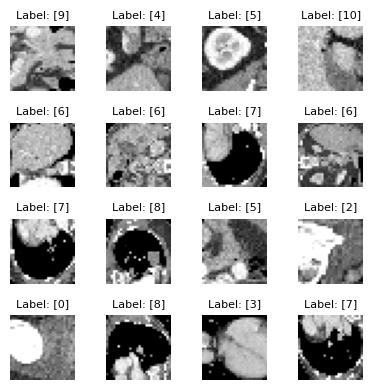

In [3]:
# select 16 random indices for plotting
indices = random.sample(range(len(train_dataset)), 16)

plt.figure(figsize=(4, 4))

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]

    # If tensor, convert to 2D array (grayscale)
    if hasattr(image, 'squeeze'):
        image = image.squeeze()  # remove channel dimension if present

    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Fully connected neural network with one hidden layer
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, n_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        #return torch.log_softmax(out, dim=1)   #for NLL los
        return out

mlp_model = MLP(input_size, hidden_size, n_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # One can try NLL Loss
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=lr) 

/home/oliver/.local/share/virtualenvs/ai-summerschool-solutions-PyaoVKZG/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GeForce MX150 which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
    
  warnings.warn(
/home/oliver/.local/share/virtualenvs/ai-summerschool-solutions-PyaoVKZG/lib/python3.12/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/home/oliver/.local/share/virtualenvs/ai-summerschool-solutions-PyaoVKZG/lib/python3.12/site-packages/torch/cuda/__init__.py:326: UserWarning: 
NVIDIA GeForce MX150 with CUDA capability sm_61 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_70 sm_

In [14]:
# Training 
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    train_correct = 0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.reshape(-1, 28*28).to(device), torch.squeeze(targets, 1).long().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(outputs, 1)
        train_correct += (predictions == targets).sum().item()
        total_samples += targets.size(0)

    train_acc = (train_correct / total_samples) * 100
    return train_acc, loss.item()


# Validation/Test
def val(model, dataloader, criterion, device):
    model.eval()
    val_correct = 0
    total_samples = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.reshape(-1, 28*28).to(device), torch.squeeze(targets, 1).long().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            _, predictions = torch.max(outputs, 1)

            val_correct += (predictions == targets).sum().item()
            total_samples += targets.size(0)
            val_loss += loss.item()

    val_acc = (val_correct / total_samples) * 100
    avg_val_loss = val_loss / len(dataloader)
    return val_acc, avg_val_loss

In [1]:
Train_Acc =[]
Train_Loss =[]

Val_Acc =[]
Val_Loss =[]

for epoch in range(n_epochs):
    train_acc, train_loss = train(mlp_model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = val(mlp_model, val_loader, criterion, device)
    print (f'Epoch--[{epoch+1}], Train_Accuracy: {train_acc}, Validation_Accuracy: {val_acc}')
    Train_Acc.append(train_acc)
    Train_Loss.append(train_loss)
    Val_Acc.append(val_acc)
    Val_Loss.append(val_loss)




# Plot Epoch vs Accuracy
plt.figure()
plt.plot(range(1, n_epochs+1), Train_Acc, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), Val_Acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
#plt.grid(True)
plt.show()

# Plot Epoch vs Loss
plt.figure()
plt.plot(range(1, n_epochs+1), Train_Loss, label='Train Loss')
plt.plot(range(1, n_epochs+1), Val_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
torch.cuda.is_available()
plt.legend()
#plt.grid(True)
plt.show()

#Testing
test_acc, test_loss = val(mlp_model, test_loader, criterion, device)
print (f'Test_Accuracy: {test_acc}')

NameError: name 'n_epochs' is not defined